In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(1)
from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB


Data generation

In [2]:
#Define the number of elements in each set I, J, K
i_num = 7
k_num = 1
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [3]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 3000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 3000), 0)

I.index = I['Point number']


for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 3000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 3000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 3000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 3000), 0)

J.index = J['Point number']
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,686.0,2836.0
j1,j1,2704.0,92.0
j2,j2,76.0,1624.0
j3,j3,2817.0,1144.0
j4,j4,650.0,1266.0
...,...,...,...
i2,i2,1486.0,1348.0
i3,i3,1955.0,2366.0
i4,i4,282.0,85.0


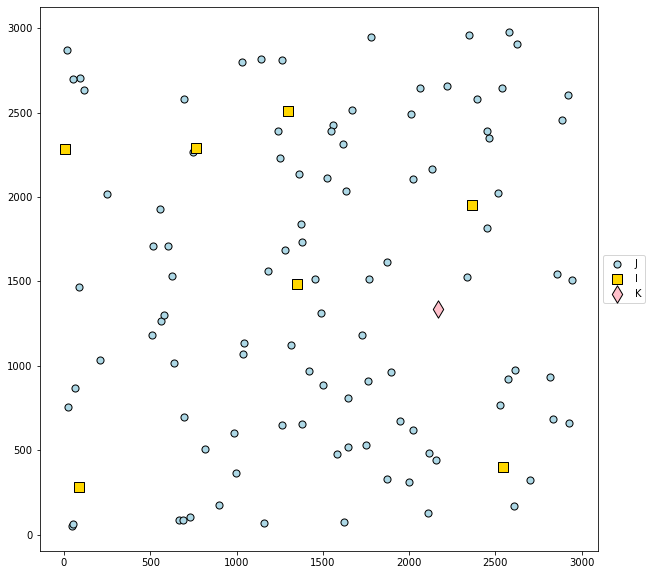

In [4]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
#Define constants

B = 91800 #battery load: meters of travel
S = 1020 #meters of service time
W = 2500 #max grams of weight

p = 0.005

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920

gamma = 0.0045 / 1000 # variable cost in euro per m

q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 200
hardlimit = 600

In [6]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

In [7]:
std_dev = {i : random.uniform(10000, 70000) for i in I.index}

#Define random variable

theta_ran_i = {}
for i in list(I.index):
    theta_ran_i[i] = foldnorm(c=0, loc=0, scale=std_dev[i]) 
    
#Define deterministic theta
theta_det = {}
for i in I.index:
    theta_det[i] = theta_ran_i[i].rvs(1)[0]
    
r = len(theta_ran_i.keys()) #r-variate random vector theta

Deterministic model DM

In [8]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

dist_KJ


{('k0', 'j0'): 934.2060800487225,
 ('k0', 'j1'): 2483.697445342327,
 ('k0', 'j2'): 1371.2333864080176,
 ('k0', 'j3'): 1798.8335109175612,
 ('k0', 'j4'): 1130.8390690102638,
 ('k0', 'j5'): 1951.9223857520565,
 ('k0', 'j6'): 678.3568382496045,
 ('k0', 'j7'): 1603.9180153611344,
 ('k0', 'j8'): 1039.3247808072315,
 ('k0', 'j9'): 2152.2755399808825,
 ('k0', 'j10'): 1277.241167516926,
 ('k0', 'j11'): 1712.2295406866451,
 ('k0', 'j12'): 1693.6318962513667,
 ('k0', 'j13'): 1519.4137027156232,
 ('k0', 'j14'): 828.5801107919499,
 ('k0', 'j15'): 1725.6679866069255,
 ('k0', 'j16'): 1164.2302177834074,
 ('k0', 'j17'): 585.7303133695575,
 ('k0', 'j18'): 1363.3037079095766,
 ('k0', 'j19'): 436.811172018299,
 ('k0', 'j20'): 1892.8267221275169,
 ('k0', 'j21'): 1401.8630460925917,
 ('k0', 'j22'): 967.9101197941883,
 ('k0', 'j23'): 785.9344756403043,
 ('k0', 'j24'): 874.0983926309441,
 ('k0', 'j25'): 254.20660888340413,
 ('k0', 'j26'): 1010.81848024262,
 ('k0', 'j27'): 2080.255993862294,
 ('k0', 'j28'): 

In [9]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")

        print("\n")


In [10]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


In [11]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))

L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [12]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))

P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0')]

In [13]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 (

In [14]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []

N_i_final = {key : val for key, val in N_i.items() if val != []}

I_feas = list(N_i_final.keys())

In [15]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []

O_j_final = {key : val for key, val in O_j.items() if val != []}

J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'k0',
 'i0',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6']

Deterministic model (DM)

In [16]:

def AddBasisGurobi(model, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit):

    #Adding basic variables x_ikj and y_j
    x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
    y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


    #Adding constraints except for demand covering
    model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
    model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
    model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
    model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

    #Set objective
    model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

    #Set parameter TimeLimit
    model.setParam('TimeLimit', hardlimit)

    return x_ikj, y_j


In [17]:

model_DM = gp.Model('DM')

x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

model_DM.optimize(softtime)

Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1598 rows, 864 columns and 1975 nonzeros
Model fingerprint: 0xfb3f8c45
Variable types: 0 continuous, 864 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 2897121.6754
Presolve removed 1555 rows and 750 columns
Presolve time: 0.02s
Presolved: 43 rows, 114 columns, 188 nonzeros
Found heuristic solution: objective 2162041.5656
Variable types: 0 continuous, 114 integer (40 binary)
Found heuristic solution: objective 2162041.5623

Root relaxation: objective 1.667567e+06, 61 iterations, 0.00 seconds (0.00 work units

In [18]:
ListSolution(model_DM)

Number of solutions found: 4
0
1.70688e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i1] 3
x_ikj[i2,k0,k0] 13
x_ikj[i3,k0,k0] 6
x_ikj[i4,k0,i4] 1
x_ikj[i5,k0,i1] 5
x_ikj[i6,k0,i1] 14
x_ikj[i6,k0,i6] 45
y_j[k0] 1
y_j[i1] 1
y_j[i4] 1
y_j[i6] 1


1
2.16204e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i1] 3
x_ikj[i2,k0,k0] 13
x_ikj[i3,k0,k0] 6
x_ikj[i4,k0,i4] 1
x_ikj[i5,k0,i1] 5
x_ikj[i6,k0,i1] 14
x_ikj[i6,k0,i6] 45
y_j[k0] 1
y_j[i1] 1
y_j[i4] 1
y_j[i6] 1


2
2.16204e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i1] 3
x_ikj[i2,k0,k0] 13
x_ikj[i3,k0,k0] 6
x_ikj[i4,k0,i4] 1
x_ikj[i5,k0,i1] 5
x_ikj[i6,k0,i1] 14
x_ikj[i6,k0,i6] 45
y_j[k0] 1
y_j[i1] 1
y_j[i4] 1
y_j[i6] 1


3
2.89712e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i1] 3
x_ikj[i2,k0,k0] 13
x_ikj[i3,k0,k0] 6
x_ikj[i4,k0,i4] 1
x_ikj[i5,k0,i1] 5
x_ikj[i6,k0,i1] 14
x_ikj[i6,k0,i6] 45
y_j[k0] 1
y_j[i1] 1
y_j[i4] 1
y_j[i6] 1






In [19]:
SolutionSummary(model_DM)

(    i  Number of drones
 0  i0                 1
 1  i1                 3
 2  i2                13
 3  i3                 6
 4  i4                 1
 5  i5                 5
 6  i6                59,
     j  Number of drones
 0  i1                22
 1  i4                 1
 2  i6                45
 3  k0                20,
     k  Number of drones
 0  k0                88,
 'Total number of drones: 88',
 'Total number of locations: 4')

In [20]:
# model_BO1 = gp.Model('BO1')

# #model_BO1.Params.Presolve = 0

# x_ikj, y_j = AddBasisGurobi(model_BO1, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
#                             alpha, beta, gamma, hardlimit)

# z_i = model_BO1.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i')

# F_i = model_BO1.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i')
# test_F_i = model_BO1.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i')



# for i in I_feas:
    
#     #Generate mapping z->cdf
#     step = 0.005
#     ones = [1] * 5
#     foldnorm_cdf_values = []
#     z_values = []
#     foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
#     z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
#     foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
#     for one in ones:
#         z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
#     model_BO1.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
#     model_BO1.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F=cdf(z_i)")
    
#     model_BO1.addConstr((F_i[i] >= p), name='Individual probabilistic constraint')
#     model_BO1.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    

# model_BO1.addConstr((gp.quicksum(F_i[i] for i in I_feas) - r + 1 >= p), name='Joint probabilistic constraint')

# model_BO1.update()

Set parameter TimeLimit to value 600


In [21]:
#model_BO1.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1613 rows, 885 columns and 2010 nonzeros
Model fingerprint: 0x52bf4a5c
Model has 7 general constraints
Variable types: 21 continuous, 864 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 6e+00]
  PWLCon x range   [2e+02, 2e+05]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 903 columns
Presolve removed 1373 rows and 0 columns
Presolve time: 0.02s
Presolved: 240 rows, 1788 columns, 24114 nonzeros
Variable types: 1435 continuous, 353 integer (112 binary)

Root relaxation: objective 2.678034e+06, 391 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |

In [22]:
#ListSolution(model_BO1)

Number of solutions found: 10
0
2.90084e+06 
x_ikj[i0,k0,k0] 20
x_ikj[i1,k0,j55] 36
x_ikj[i2,k0,j55] 19
x_ikj[i3,k0,k0] 25
x_ikj[i4,k0,i4] 13
x_ikj[i5,k0,j55] 16
x_ikj[i6,k0,j55] 31
y_j[j55] 1
y_j[k0] 1
y_j[i4] 1
z_i[i0] 50000
z_i[i1] 90000
z_i[i2] 47500
z_i[i3] 62500
z_i[i4] 32500
z_i[i5] 40000
z_i[i6] 77500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
test_F_i[i0] 799364
test_F_i[i1] 807033
test_F_i[i2] 951427
test_F_i[i3] 757029
test_F_i[i4] 968782
test_F_i[i5] 952465
test_F_i[i6] 769308


1
2.90084e+06 
x_ikj[i0,k0,k0] 20
x_ikj[i1,k0,j55] 36
x_ikj[i2,k0,j55] 19
x_ikj[i3,k0,k0] 25
x_ikj[i4,k0,i4] 13
x_ikj[i5,k0,j55] 16
x_ikj[i6,k0,j55] 31
y_j[j55] 1
y_j[k0] 1
y_j[i4] 1
z_i[i0] 50000
z_i[i1] 90000
z_i[i2] 47500
z_i[i3] 62500
z_i[i4] 32500
z_i[i5] 40000
z_i[i6] 77500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
test_F_i[i0] 799364
test_F_i[i1] 807033
test_F_i[i2] 951427
test_F_i[i3] 757029
test_F_i[i4] 968782
test_F_i[i5] 952465
test_F

In [23]:
#SolutionSummary(model_BO1)

(    i  Number of drones
 0  i0                20
 1  i1                36
 2  i2                19
 3  i3                25
 4  i4                13
 5  i5                16
 6  i6                31,
      j  Number of drones
 0   i4                13
 1  j55               102
 2   k0                45,
     k  Number of drones
 0  k0               160,
 'Total number of drones: 160',
 'Total number of locations: 3')

In [25]:
model_BO2 = gp.Model('BO2')

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO2, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO2.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i') #half-normally distributed variable
F_i = model_BO2.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i') #marginal distribution
test_F_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i') #because of rounding precision
test_q_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_q_i') #because of rounding precision

q_i = model_BO2.addVars(I_feas, lb=p, ub=1, vtype = GRB.CONTINUOUS, name='q_i') #auxiliary variable


for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.005
    ones = [1] * 5
    foldnorm_cdf_values = []
    z_values = []
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO2.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO2.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F_i=cdf(z_i)")
    
    model_BO2.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    model_BO2.addConstr(test_q_i[i] == q_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    model_BO2.addConstr((F_i[i] >= q_i[i]), name='Joint probabilistic constraint')
    

model_BO2.addConstr(1 - p >= (gp.quicksum(1 - q_i[i] for i in I_feas)), name='Auxiliary constraint')

model_BO2.update()

Set parameter TimeLimit to value 600


In [26]:
model_BO2.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1620 rows, 899 columns and 2031 nonzeros
Model fingerprint: 0x580bc2c5
Model has 7 general constraints
Variable types: 35 continuous, 864 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [5e-03, 1e+00]
  RHS range        [1e+00, 6e+00]
  PWLCon x range   [2e+02, 2e+05]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 889 columns
Presolve removed 1380 rows and 0 columns
Presolve time: 0.02s
Presolved: 240 rows, 1788 columns, 24114 nonzeros
Variable types: 1435 continuous, 353 integer (112 binary)

Root relaxation: objective 2.678034e+06, 391 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |

In [27]:
ListSolution(model_BO2)

Number of solutions found: 10
0
2.90084e+06 
x_ikj[i0,k0,k0] 20
x_ikj[i1,k0,j55] 36
x_ikj[i2,k0,j55] 19
x_ikj[i3,k0,k0] 25
x_ikj[i4,k0,i4] 13
x_ikj[i5,k0,j55] 16
x_ikj[i6,k0,j55] 31
y_j[j55] 1
y_j[k0] 1
y_j[i4] 1
z_i[i0] 50000
z_i[i1] 90000
z_i[i2] 47500
z_i[i3] 62500
z_i[i4] 32500
z_i[i5] 40000
z_i[i6] 77500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
test_F_i[i0] 799364
test_F_i[i1] 807033
test_F_i[i2] 951427
test_F_i[i3] 757029
test_F_i[i4] 968782
test_F_i[i5] 952465
test_F_i[i6] 769308
test_q_i[i0] 799364
test_q_i[i1] 807033
test_q_i[i2] 951427
test_q_i[i3] 757029
test_q_i[i4] 968782
test_q_i[i5] 952465
test_q_i[i6] 769308
q_i[i0] 0
q_i[i1] 0
q_i[i2] 0
q_i[i3] 0
q_i[i4] 0
q_i[i5] 0
q_i[i6] 0


1
2.90084e+06 
x_ikj[i0,k0,k0] 20
x_ikj[i1,k0,j55] 36
x_ikj[i2,k0,j55] 19
x_ikj[i3,k0,k0] 25
x_ikj[i4,k0,i4] 13
x_ikj[i5,k0,j55] 16
x_ikj[i6,k0,j55] 31
y_j[j55] 1
y_j[k0] 1
y_j[i4] 1
z_i[i0] 50000
z_i[i1] 90000
z_i[i2] 47500
z_i[i3] 62500
z_i[i4] 32500
z_i[i5] 40000


In [28]:
SolutionSummary(model_BO2)

(    i  Number of drones
 0  i0                20
 1  i1                36
 2  i2                19
 3  i3                25
 4  i4                13
 5  i5                16
 6  i6                31,
      j  Number of drones
 0   i4                13
 1  j55               102
 2   k0                45,
     k  Number of drones
 0  k0               160,
 'Total number of drones: 160',
 'Total number of locations: 3')

In [30]:

#Generate mapping prob->quantile
step = 0.005
ones = [1] * 5
z_values = []
prob_values = []
prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev['i0']).tolist()
prob_values = np.append(prob_values, ones)

for one in ones:
    z_values = np.append(z_values, z_values[-1]+50*one)

In [31]:
model_BO3 = gp.Model('BO3')

x_ikj, y_j = AddBasisGurobi(model_BO3, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

F_quant_i = model_BO3.addVars(I_feas, vtype = GRB.CONTINUOUS, name='F_quant_i')
prob = model_BO3.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name='prob')


model_BO3.addConstr((prob == 1-(1-p)/r), name = 'Prob replacement')


for i in I_feas:
    
    step = 0.005
    ones = [1] * 5
    z_values = []
    prob_values = []
    prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    prob_values = np.append(prob_values, ones)

    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
    
    model_BO3.addGenConstrPWL(xvar=prob, yvar=F_quant_i[i], xpts=prob_values, ypts=z_values, name="F1=ppf(prob)")
    
    model_BO3.addConstr((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= F_quant_i[i]), name = 'Joint probabilistic constraint')

model_BO3.update()

Set parameter TimeLimit to value 600


In [32]:
model_BO3.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1599 rows, 872 columns and 1983 nonzeros
Model fingerprint: 0x27a81cc1
Model has 7 general constraints
Variable types: 8 continuous, 864 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+00]
  PWLCon x range   [1e-02, 1e+00]
  PWLCon y range   [2e+02, 2e+05]
Presolve removed 1486 rows and 575 columns
Presolve time: 0.01s
Presolved: 113 rows, 297 columns, 489 nonzeros
Variable types: 0 continuous, 297 integer (105 binary)
Found heuristic solution: objective 3591922.6203
Found heuristic solution: objective 3136762.5028

Root relaxation: objective 3.057537e+06, 162 iterations, 0.00 seconds

In [33]:
ListSolution(model_BO3)

Number of solutions found: 5
0
3.13676e+06 
x_ikj[i0,k0,k0] 23
x_ikj[i1,k0,j55] 41
x_ikj[i2,k0,k0] 15
x_ikj[i3,k0,k0] 7
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,i4] 9
x_ikj[i5,k0,j55] 12
x_ikj[i6,k0,j55] 38
y_j[j55] 1
y_j[k0] 1
y_j[i3] 1
y_j[i4] 1
F_quant_i[i0] 57351
F_quant_i[i1] 101477
F_quant_i[i2] 35345
F_quant_i[i3] 78574
F_quant_i[i4] 22137
F_quant_i[i5] 29625
F_quant_i[i6] 94914
prob 0


1
3.13676e+06 
x_ikj[i0,k0,k0] 23
x_ikj[i1,k0,j55] 41
x_ikj[i2,k0,k0] 15
x_ikj[i3,k0,k0] 7
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,i4] 9
x_ikj[i5,k0,j55] 12
x_ikj[i6,k0,j55] 38
y_j[j55] 1
y_j[k0] 1
y_j[i3] 1
y_j[i4] 1
F_quant_i[i0] 57351
F_quant_i[i1] 101477
F_quant_i[i2] 35345
F_quant_i[i3] 78574
F_quant_i[i4] 22137
F_quant_i[i5] 29625
F_quant_i[i6] 94914
prob 0


2
3.13676e+06 
x_ikj[i0,k0,k0] 23
x_ikj[i1,k0,j55] 41
x_ikj[i2,k0,k0] 15
x_ikj[i3,k0,k0] 7
x_ikj[i3,k0,i3] 25
x_ikj[i4,k0,i4] 9
x_ikj[i5,k0,j55] 12
x_ikj[i6,k0,j55] 38
y_j[j55] 1
y_j[k0] 1
y_j[i3] 1
y_j[i4] 1
F_quant_i[i0] 57351
F_quant_i[i1] 101477
F_q

In [34]:
SolutionSummary(model_BO3)

(    i  Number of drones
 0  i0                23
 1  i1                41
 2  i2                15
 3  i3                32
 4  i4                 9
 5  i5                12
 6  i6                38,
      j  Number of drones
 0   i3                25
 1   i4                 9
 2  j55                91
 3   k0                45,
     k  Number of drones
 0  k0               170,
 'Total number of drones: 170',
 'Total number of locations: 4')

In [36]:
def Robustness_Summary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    #results_doctors['Prob Number of drones'] = results_doctors['Number of drones'].astype(int)
    return results_doctors

In [37]:
def Robustness(model_PM):
    robustness_df = Robustness_Summary(model_PM)
    robustness_df['DM Number of drones'] = Robustness_Summary(model_DM)['Number of drones']

    # Calculate the difference between 'Number of drones' and 'DM Number of drones'
    difference = robustness_df['Number of drones'] - robustness_df['DM Number of drones']

    # Assign 'Drones uncovered' column based on the condition
    robustness_df['Drones uncovered'] = np.where(difference >= 0, 0, abs(difference))
    robustness = 1 - sum(robustness_df['Drones uncovered']) / sum(robustness_df['DM Number of drones'])
    return robustness_df, robustness

In [39]:
Robustness(model_BO2)

(    i  Number of drones  DM Number of drones  Drones uncovered
 0  i0                20                    1                 0
 1  i1                36                    3                 0
 2  i2                19                   13                 0
 3  i3                25                    6                 0
 4  i4                13                    1                 0
 5  i5                16                    5                 0
 6  i6                31                   59                28,
 0.6818181818181819)

In [40]:
Robustness(model_BO3)

(    i  Number of drones  DM Number of drones  Drones uncovered
 0  i0                23                    1                 0
 1  i1                41                    3                 0
 2  i2                15                   13                 0
 3  i3                32                    6                 0
 4  i4                 9                    1                 0
 5  i5                12                    5                 0
 6  i6                38                   59                21,
 0.7613636363636364)